In [1]:
import pandas as pd
import numpy as np

# Leer el archivo CSV
df = pd.read_csv('data/edges.csv')

# Obtener la lista única de nodos
nodos = pd.unique(df[['Node 1', 'Node 2']].values.ravel())

# Crear un DataFrame vacío con nodos como índices y columnas
matriz_similitud = pd.DataFrame(np.nan, index=nodos, columns=nodos)

# Rellenar la matriz con los valores de Cosine Similarity
for _, row in df.iterrows():
    nodo1 = row['Node 1']
    nodo2 = row['Node 2']
    similitud = row['Cosine Similarity']
    matriz_similitud.at[nodo1, nodo2] = similitud
    matriz_similitud.at[nodo2, nodo1] = similitud  # Si la matriz es simétrica

# Opcional: Reemplazar NaN con 0 si no hay similitud
matriz_similitud.fillna(0, inplace=True)

# Mostrar la matriz
print(matriz_similitud)

          0         1         2         3         4         5         6    \
0    1.000000  0.292175  0.190988  0.930130  0.739198  0.204643  0.718866   
1    0.292175  1.000000  0.020367  0.228254  0.740619  0.503669  0.612969   
2    0.190988  0.020367  1.000000  0.763313  0.095786  0.108807  0.947075   
3    0.930130  0.228254  0.763313  1.000000  0.385397  0.283478  0.994613   
4    0.739198  0.740619  0.095786  0.385397  1.000000  0.460467  0.042518   
..        ...       ...       ...       ...       ...       ...       ...   
868  0.883225  0.539945  0.771885  0.956333  0.342873  0.996313  0.890561   
869  0.123906  0.861112  0.831659  0.491609  0.234419  0.376797  0.355218   
870  0.049614  0.622450  0.795086  0.549600  0.138906  0.290454  0.959631   
871  0.374052  0.456566  0.580083  0.476781  0.181017  0.157808  0.769890   
872  0.028317  0.852278  0.328805  0.284569  0.074611  0.801351  0.279295   

          7         8         9    ...       863       864       865  \
0  

In [2]:
import pandas as pd

# Paso 1: Leer los archivos CSV
targets_df = pd.read_csv('data/targets_con_palabras_clave_agrupadas.csv')
nodes_df = pd.read_csv('data/nodes.csv')

# Mostrar los DataFrames leídos (opcional)
print("DataFrame de Targets:")
print(targets_df)
print("\nDataFrame de Nodes:")
print(nodes_df)

# Paso 2: Crear un diccionario para mapear palabras a Node IDs
# Convertir las palabras a minúsculas para asegurar una correspondencia insensible a mayúsculas
nodes_dict = dict(zip(nodes_df['Word'].str.lower(), nodes_df['Node ID']))

print("\nDiccionario de Mapeo (Word -> Node ID):")
print(nodes_dict)

# Inicializar un conjunto para almacenar las palabras clave no encontradas
missing_keywords = set()

# Paso 3: Definir una función para mapear palabras clave a Node IDs
def map_keywords_to_node_ids(keywords, mapping_dict, missing_set):
    """
    Toma una cadena de palabras clave separadas por comas y devuelve una lista de Node IDs correspondientes.
    Añade las palabras no encontradas al conjunto missing_set.
    
    Parámetros:
    - keywords (str): Cadena de palabras clave separadas por comas.
    - mapping_dict (dict): Diccionario que mapea palabras a Node IDs.
    - missing_set (set): Conjunto para almacenar palabras no encontradas.
    
    Retorna:
    - list: Lista de Node IDs correspondientes a las palabras clave encontradas.
    """
    if pd.isna(keywords):
        return []
    
    # Dividir las palabras clave por comas y eliminar espacios en blanco
    words = [word.strip().lower() for word in keywords.split(',')]
    
    # Mapear cada palabra a su Node ID si existe en el diccionario
    node_ids = []
    for word in words:
        if word in mapping_dict:
            node_ids.append(mapping_dict[word])
        else:
            missing_set.add(word)
    
    return node_ids

# Paso 4: Aplicar la función al DataFrame de Targets para crear la nueva columna
targets_df['Node_IDs'] = targets_df['palabras_clave_concatenadas'].apply(
    lambda x: map_keywords_to_node_ids(x, nodes_dict, missing_keywords)
)

# Paso 5: Mostrar el DataFrame resultante
print("\nDataFrame Final con Node_IDs:")
print(targets_df)

# Paso 6: Guardar el DataFrame resultante en un archivo CSV (opcional)
targets_df.to_csv('targets_with_node_ids.csv', index=False)
print("\nEl DataFrame con Node_IDs ha sido guardado en 'targets_with_node_ids.csv'")

# Paso 7: Mostrar y/o guardar la lista de palabras clave no encontradas
if missing_keywords:
    print("\nPalabras clave no encontradas en 'nodes.csv':")
    for keyword in sorted(missing_keywords):
        print(f"- {keyword}")
    
    # Guardar las palabras clave faltantes en un archivo de texto
    with open('missing_keywords.txt', 'w', encoding='utf-8') as f:
        for keyword in sorted(missing_keywords):
            f.write(f"{keyword}\n")
    print("\nLa lista de palabras clave no encontradas ha sido guardada en 'missing_keywords.txt'")
else:
    print("\nTodas las palabras clave fueron encontradas en 'nodes.csv'.")


DataFrame de Targets:
     goal_id target_id                                             target  \
0          1       1.1  By 2030, eradicate extreme poverty for all peo...   
1          1       1.2  By 2030, reduce at least by half the proportio...   
2          1       1.3  Implement nationally appropriate social protec...   
3          1       1.4  By 2030, ensure that all men and women, in par...   
4          1       1.5  By 2030, build the resilience of the poor and ...   
..       ...       ...                                                ...   
164       17     17.15  Respect each country’s policy space and leader...   
165       17     17.16  Enhance the global partnership for sustainable...   
166       17     17.17  Encourage and promote effective public, public...   
167       17     17.18  By 2020, enhance capacity-building support to ...   
168       17     17.19  By 2030, build on existing initiatives to deve...   

                           palabras_clave_concatenada

In [3]:
# Obtener la lista única de target_ids
target_ids = targets_df['target_id'].unique()

# Crear un DataFrame vacío para la matriz de similitud entre targets
matriz_target_similitud = pd.DataFrame(
    np.zeros((len(target_ids), len(target_ids))),
    index=target_ids,
    columns=target_ids
)

def calcular_media_similitud(node_ids_1, node_ids_2, matriz_similitud):
    """
    Calcula la media de las similitudes entre todos los pares de Node IDs entre dos listas.
    
    Parámetros:
    - node_ids_1 (list): Lista de Node IDs para el primer target
    - node_ids_2 (list): Lista de Node IDs para el segundo target
    - matriz_similitud (DataFrame): Matriz de similitud entre Node IDs
    
    Retorna:
    - float: Media de las similitudes
    """
    if not node_ids_1 or not node_ids_2:
        return np.nan  # Retornar NaN si alguna lista está vacía
    
    similitudes = []
    for node1 in node_ids_1:
        for node2 in node_ids_2:
            try:
                similitud = matriz_similitud.at[node1, node2]
                similitudes.append(similitud)
            except KeyError:
                # Si el Node ID no existe en la matriz de similitud
                continue
    
    if similitudes:
        return np.mean(similitudes)
    else:
        return np.nan  # Retornar NaN si no hay similitudes
    
# Iterar sobre todos los pares de target_ids
for target1 in target_ids:
    node_ids_1 = targets_df.loc[targets_df['target_id'] == target1, 'Node_IDs'].values[0]
    for target2 in target_ids:
        node_ids_2 = targets_df.loc[targets_df['target_id'] == target2, 'Node_IDs'].values[0]
        media_similitud = calcular_media_similitud(node_ids_1, node_ids_2, matriz_similitud)
        matriz_target_similitud.at[target1, target2] = media_similitud

# Guardar la matriz de similitud entre targets en un archivo CSV
matriz_target_similitud.to_csv('matriz_target_similitud.csv')
print("\nLa matriz de similitud entre targets ha sido guardada en 'matriz_target_similitud.csv'")

# Mostrar la matriz de similitud entre targets (opcional)
print("\nMatriz de Similitud entre Targets:")
print(matriz_target_similitud)


La matriz de similitud entre targets ha sido guardada en 'matriz_target_similitud.csv'

Matriz de Similitud entre Targets:
            1.1       1.2       1.3       1.4       1.5       1.a       1.b  \
1.1    0.818480  0.818480  0.425774  0.395338  0.766026  0.542195  0.818480   
1.2    0.818480  1.000000  0.371083  0.315837  0.722836  0.574111  0.818480   
1.3    0.425774  0.371083  0.520042  0.558790  0.529018  0.576450  0.425774   
1.4    0.395338  0.315837  0.558790  0.672140  0.555910  0.546291  0.395338   
1.5    0.766026  0.722836  0.529018  0.555910  0.834386  0.546853  0.766026   
...         ...       ...       ...       ...       ...       ...       ...   
17.15  0.598683  0.692874  0.487007  0.597586  0.514778  0.600356  0.598683   
17.16  0.420344  0.618222  0.614831  0.566082  0.388375  0.583440  0.420344   
17.17  0.966257  0.950128  0.511629  0.537360  0.374217  0.514594  0.966257   
17.18  0.483572  0.566636  0.558819  0.596794  0.471442  0.583720  0.483572   
17.19  

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Transformar el DataFrame en una lista de aristas (omitiendo autoedges)
edges = []
for row in matriz_target_similitud.index:
    for col in matriz_target_similitud.columns:
        if row != col:  # Omitir autoedges
            edges.append((row, col, matriz_target_similitud.loc[row, col]))

# Crear el grafo
G = nx.Graph()
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

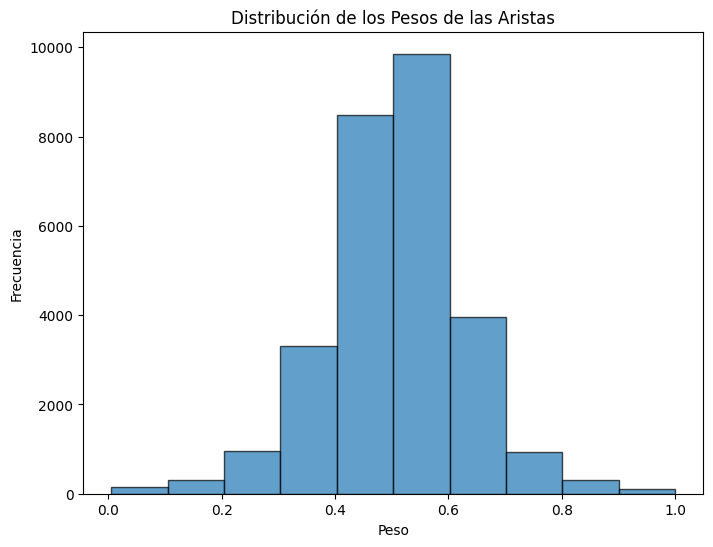

In [8]:
# Hallar la distribución de los valores
weights = [edge[2] for edge in edges]

# Graficar la distribución de los pesos
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=10, edgecolor="k", alpha=0.7)
plt.title("Distribución de los Pesos de las Aristas")
plt.xlabel("Peso")
plt.ylabel("Frecuencia")
plt.show()

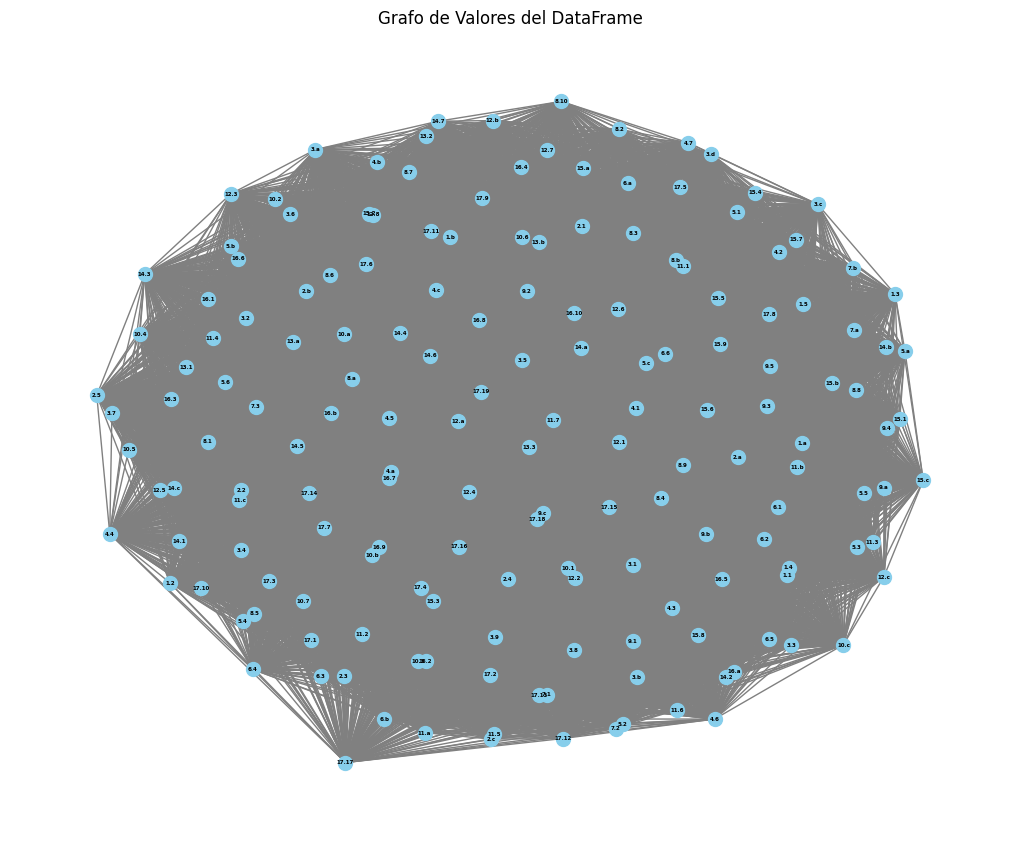

In [13]:
# [16, 736]
# Dibujar el grafo
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout para mejor visualización
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="skyblue",
    edge_color="gray",
    node_size=100,
    font_size=4,
    font_weight="bold",
)
labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
plt.title("Grafo de Valores del DataFrame")
plt.show()